In [217]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2

In [218]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load data

In [397]:
train_ds = MNIST(root="../data", train=True, download=True)
test_ds = MNIST(root="../data", train=False, download=True)
display(train_ds)
display(test_ds)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

## Split data

In [398]:
# Splitting to train and valid
train_ds, val_ds = random_split(train_ds, [50000, 10000])
print("Train size: ", len(train_ds))
print("Val size: ", len(val_ds))
print("Test size: ", len(test_ds))

Train size:  50000
Val size:  10000
Test size:  10000


## Data augmentation

In [399]:
class MyDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.ds[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.ds)

In [400]:
train_transform = v2.Compose([
    v2.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToImageTensor(), v2.ConvertDtype(),
])

val_transform = v2.Compose([
    v2.ToImageTensor(), v2.ConvertDtype(),
])

test_transform = val_transform

train_ds = MyDataset(train_ds, train_transform)
val_ds = MyDataset(val_ds, val_transform)

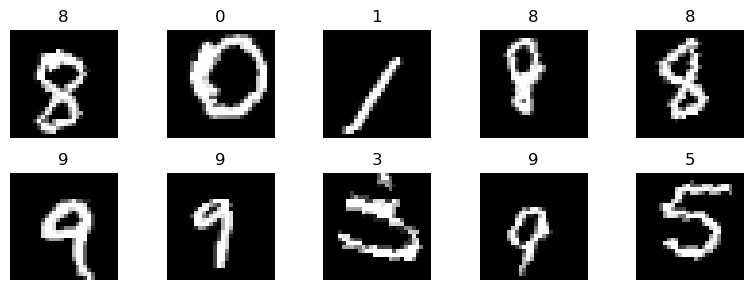

In [401]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))

for i, ax in enumerate(axes.flat):
    image, label = train_ds[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()

## Model: CNN architecture

In [402]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(1568, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 10)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return x

In [403]:
model = CNN()
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = F.cross_entropy

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True)

In [404]:
model

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128

## Training loop

In [405]:
def accuracy(preds, y_true): 
    return (torch.argmax(preds, dim=1) == y_true).float().mean()

In [406]:
from tqdm import tqdm

epochs = 5
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in tqdm(range(epochs)):
    epoch_loss, acc = 0, 0
    model.train()
    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        
        preds = model(Xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_loss += loss.item()
        acc += accuracy(preds, yb)

    train_loss.append(epoch_loss / len(train_loader))
    train_acc.append(acc / len(train_loader))


    epoch_loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            
            preds = model(Xb)
            loss = loss_func(preds, yb)

            epoch_loss += loss.item()
            acc += accuracy(preds, yb)

    val_loss.append(epoch_loss / len(val_loader))
    val_acc.append(acc / len(val_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}], ",
        f"Train loss: {train_loss[-1]:.4f}, ",
        f"Train acc: {train_acc[-1]:.4f}, ",
        f"Val loss: {val_loss[-1]:.4f}, ",
        f"Val acc: {val_acc[-1]:.4f}",
    )

 20%|██        | 1/5 [01:44<06:56, 104.20s/it]

Epoch [1/5],  Train loss: 0.5950,  Train acc: 0.8395,  Val loss: 0.0807,  Val acc: 0.9778


 40%|████      | 2/5 [03:36<05:26, 108.78s/it]

Epoch [2/5],  Train loss: 0.2318,  Train acc: 0.9304,  Val loss: 0.0709,  Val acc: 0.9771


 60%|██████    | 3/5 [05:28<03:40, 110.35s/it]

Epoch [3/5],  Train loss: 0.1891,  Train acc: 0.9422,  Val loss: 0.0463,  Val acc: 0.9856


 80%|████████  | 4/5 [07:17<01:49, 109.71s/it]

Epoch [4/5],  Train loss: 0.1664,  Train acc: 0.9491,  Val loss: 0.0431,  Val acc: 0.9861


100%|██████████| 5/5 [08:40<00:00, 104.09s/it]

Epoch [5/5],  Train loss: 0.1542,  Train acc: 0.9532,  Val loss: 0.0359,  Val acc: 0.9886


In [407]:
X_test = test_transform(test_ds.data).unsqueeze(1)
y_test = test_ds.targets

In [408]:
model.eval()
accuracy(model(X_test), y_test)


tensor(0.9913)

In [409]:
torch.save(model, "../models/cnn_improved.pth")

tensor(7)
tensor(7)
tensor([[-7.5425, -0.9985, -1.0576, -1.1407, -4.1061, -5.1917, -9.7851,  9.5434,
         -5.1226,  0.0566]], grad_fn=<AddmmBackward0>)


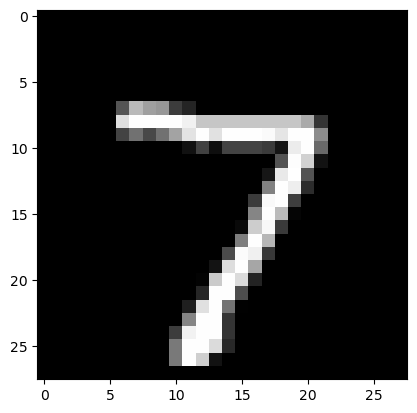

In [410]:
num = 0
print(y_test[num])
print(torch.argmax(model(X_test[num].unsqueeze(0))))
print(model(X_test[num].unsqueeze(0)))
plt.imshow(X_test[num].squeeze(), cmap="gray")